In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
if not os.path.exists('figures/BCP'):
    os.makedirs('figures/BCP')


# the switching binomial generative model


In [3]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'
observer = 'AM'
mode = 'pari'
from aSPEM import Analysis
import bayesianchangepoint as bcp
e = Analysis(observer=observer, mode=mode)

/!\ Le fichier Delete n'existe pas pour fct_velocity_2_step_False_whitening !


# chosen readout with a comparison with 'fixed'

/usr/local/lib/python3.5/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


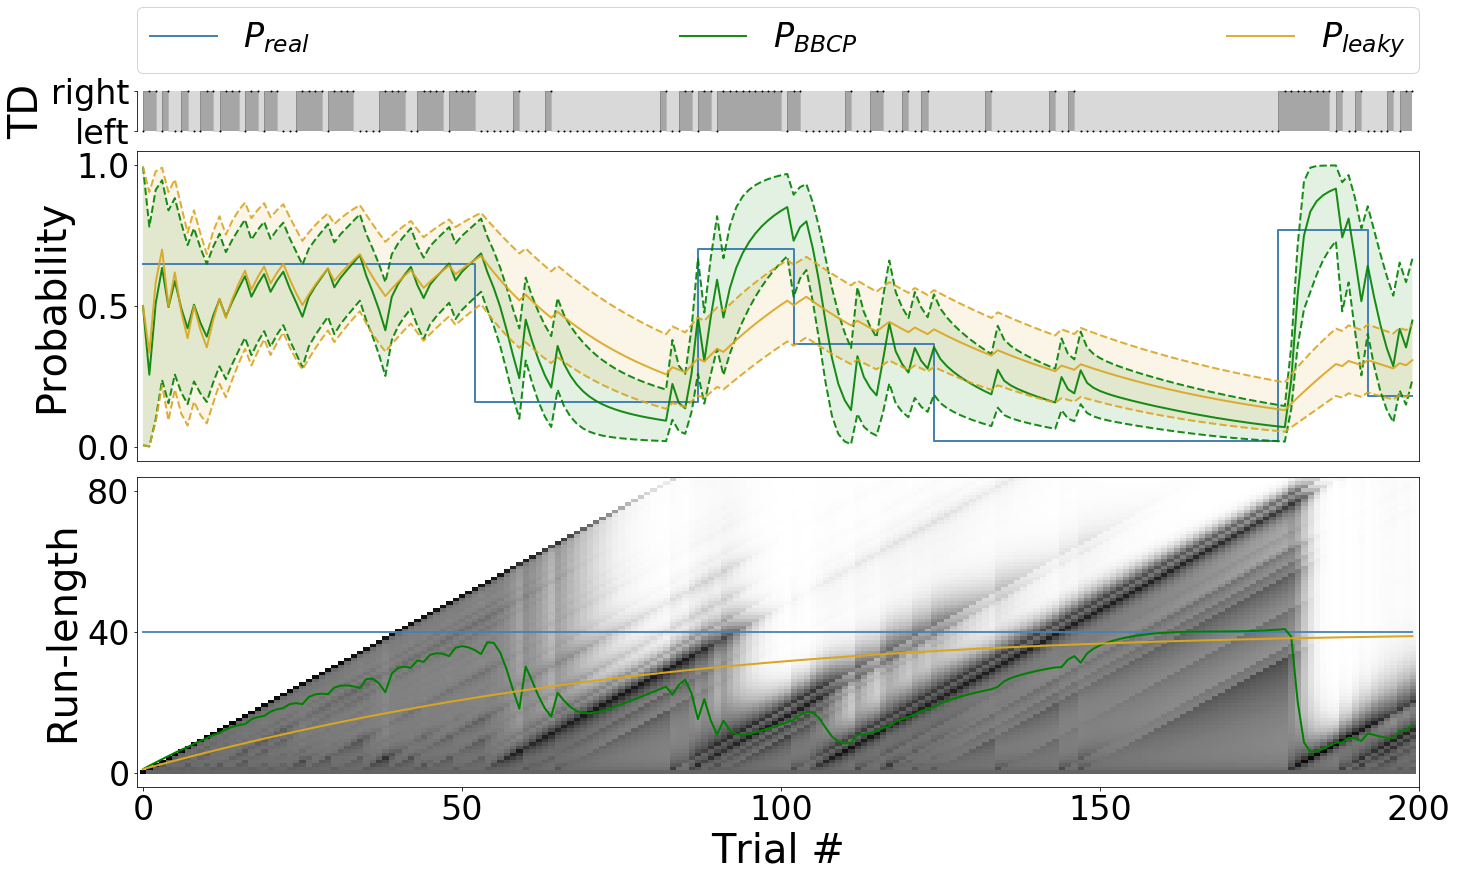

In [4]:
fig_width_f = 2*(fig_width/3)
t_titre_f = t_titre
t_label_f = t_label


figname = '3_BCP_readouts'
num_block = 0

color = [['k', 'k'], [color_true_p, color_true_p], ['k','w']]
alpha = [[.35,.15],[.0,.0],[1,0]]
fig1, ax0, ax1, ax2 = e.plot_bcp(mode=['mean'], mode_compare='leaky', block=num_block, trial=50, max_run_length=85, 
                           c_mode=color_bcp_mean, c_compare=color_bcp_fix, color=color,
                           N_scan=0, show_title=None, show_trial=False, fig_width=fig_width_f, t_label=t_label_f,
                           leg_up=True, TD=True, alpha=alpha)
for ext in exts: fig1.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)

In [5]:
ax0_pos = ax0.get_position().bounds
ax1_pos = ax1.get_position().bounds
ax2_pos = ax2.get_position().bounds

In [6]:
print(ax0_pos, ax1_pos, ax2_pos)

(0.07989583333333333, 0.8411091440831077, 0.8904253472222223, 0.050000000000000044) (0.07989583333333333, 0.47252826079053484, 0.8904253472222223, 0.3485808832925728) (0.07989583333333333, 0.10651833333333338, 0.8904253472222223, 0.3485808832925728)


# the online BCP model: figures for the model

In [7]:
N_trials = 15 # 100
seed = 7
np.random.seed(seed)
p0, r0 =  0.5, 1.0
trials = np.arange(N_trials)
p = np.random.rand(N_trials, 3)
p[:, 2] = 0
p[N_trials//2, 2] = 1

p[:N_trials//2, 1] = .5 #.15
p[N_trials//2:, 1] = .9 #.85

for trial in trials:
    p[trial, 0] =  p[trial, 1] > np.random.rand() # Bernouilli trial

tau = N_trials//2
h = 1/tau
p_bar, r_bar, beliefs = bcp.inference(p[:, 0], h=h, p0=p0, r0=r0)
#p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='max', p0=p0)
#p_hat, r_hat_mean = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=p0)
#p_hat, r_hat_leaky = bcp.readout(p_bar, r_bar, beliefs, mode='leaky', p0=p0)


def arrow_1(ax, x, y, alpha):
    plt.arrow(x+(r_cir), y+(r_cir/2), 3-(r_cir*2), 1-(r_cir),
              head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha,
              length_includes_head=True, lw=2)

def arrow_2(ax, x, y, alpha):
    if y==0 : y1=0 ; y2=0 ; x1=x+r_cir+r_cir*0.3 ; x2=2.75-(r_cir*2)-r_cir*0.3
    else :    y1=y-(r_cir/2) ; y2=-y+r_cir ; x1=x+r_cir ; x2=2.75-(r_cir*2)
    
    plt.arrow(x1, y1, x2, y2,
              head_width=s_arrow, head_length=s_arrow, fc=c_f2, ec=c_f2, alpha=0.4,
              length_includes_head=True,  lw=2)
r_cir, lw_cir, s_arrow = 0.3, 3, 0.1 # 0.2, 3, 0.09
c_f1, c_f2, c_cir = 'k', 'k', 'k' #'k', 'r', 'k'
num = N_trials
alpha = .2

In [8]:
#fig_width_f = (fig1.get_size_inches()[0])/2
#fig_width1_f = (fig1.get_size_inches()[1])

t_titre_f = t_titre
t_label_f = t_label

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


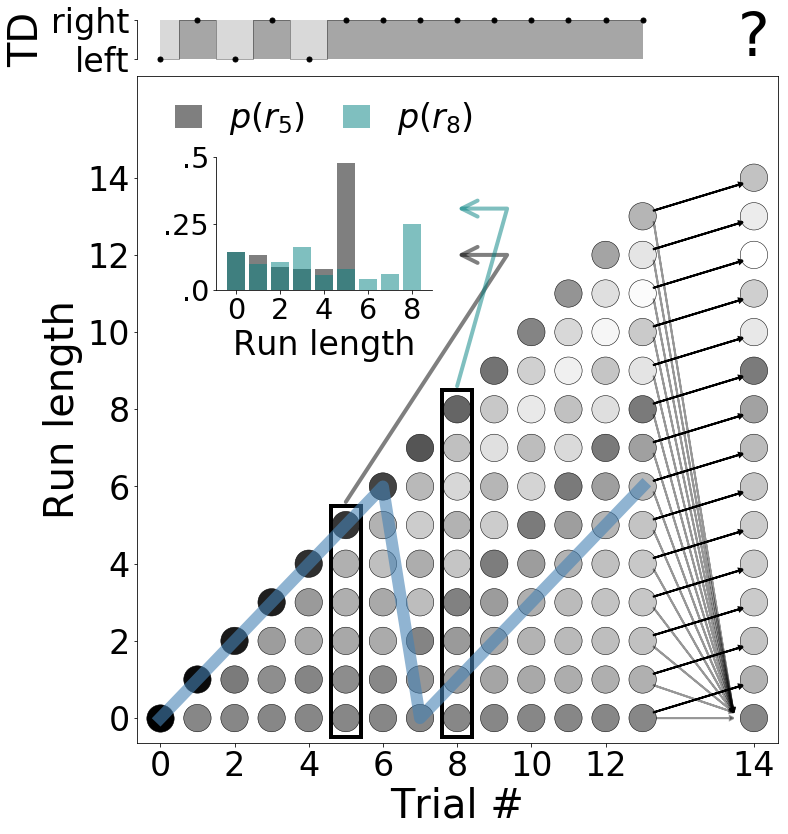

In [9]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolor


fig, axs = plt.subplots(2, 1, figsize=(fig_width_f, (fig_width_f)/(1.6180)))

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0, bottom=0.85, right=0.5, top=1.-0.05, hspace=0)
axs[0] = plt.subplot(gs1[0])

for card in ['bottom', 'top', 'right']: axs[0].spines[card].set_visible(False)
axs[0].spines['left'].set_bounds(0, 1)
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(['left','right'],fontsize=t_label_f/1.8)
axs[0].spines['left'].set_bounds(0, 1)
ec = 0.2
color=[['k', 'k'], [color_true_p, color_true_p], ['k','none']]
Alpha = [[.35,.15],[.0,.0],[1,0]]

x = np.arange(N_trials-1)
y = p[:-1, 0]


axs[0].plot(x, y, 'k.', ms=10)
axs[0].step(x, y, lw=1, c=color[0][0], alpha=Alpha[0][0], where='mid')
axs[0].fill_between(x, np.zeros_like(y), y, lw=.5, alpha=Alpha[0][0], facecolor=color[0][0], step='mid')
axs[0].fill_between(x, np.ones_like(y), y, lw=.5, alpha=Alpha[0][1], facecolor=color[0][1], step='mid')
axs[0].text(N_trials+1, 0.5, '?', fontsize=t_label_f, va='center', ha='center')

axs[0].set_ylabel('TD', fontsize=t_label_f/1.5)
axs[0].set_xticks(())

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0, bottom=0-0.05, right=0.5, top=0.85-0.01, hspace=0)
axs[1] = plt.subplot(gs2[0])
ax=axs[1]

for a in axs :
    a.set_xlim(-0.1,N_trials+0.1)
    a.tick_params(labelsize=t_label_f/(1.8))


l_log = []
for b in range(len(beliefs)) : l_log.extend([x for x in np.log(beliefs[b]) if x != float('-inf')])
    
for x in (trials-1):
    if x < num: runlengths = range(x+1)
    else:       runlengths = range(num)
    
    ax.scatter(np.ones(x+1)*x, range(x+1), s=750, c=np.log(beliefs[:x+1, x]), alpha=1, edgecolors='k', lw=0.5,
               cmap='Greys', norm=mcolor.Normalize(vmin=np.min(l_log), vmax=np.max(l_log)))
    
x = len(trials)-1
for r in range(x): arrow_1(ax, x-1, r, alpha=1) ; arrow_2(ax, x-1, r, alpha=1)
ax.scatter(np.ones(x+1)*(x+2), range(x+1), s=750, c=np.log(beliefs[:x+1, x]), alpha=1, edgecolors='k', lw=0.5,
               cmap='Greys', norm=mcolor.Normalize(vmin=np.min(l_log), vmax=np.max(l_log)))

#ax.plot(r_hat-1, lw=6, alpha=0.6, c='k')
#ax.plot(r_hat_mean-1, lw=6, alpha=0.6, c=color_bcp_mean)
#ax.plot(r_hat_leaky-1, lw=6, alpha=0.6, c=color_bcp_fix)

r_true = np.arange(N_trials)
r_true[N_trials//2:] = np.arange(N_trials//2+1)

ax.plot(r_true[:-1], lw=12, alpha=0.6, c=color_true_p)

ax.tick_params(bottom=True, top=False, right=False, left=True)
ax.set_ylabel('Run length', fontsize=t_label_f/1.5)
ax.set_xlabel('Trial #', fontsize=t_label_f/1.5)
ax.set_xticks([0,2,4,6,8,10,12, 16])
ax.set_xticklabels([0,2,4,6,8,10,12, 14])
ax.set_yticks(np.arange(0, N_trials, 2))
#ax.set_xticklabels(np.arange(0, N_trials, 2))
#ax.set_yticklabels(np.arange(0, N_trials, 2))



a1 = fig.add_axes([0.135, 0.58, 0.15,0.15])
connectionstyle = "arc,angleA=-90,angleB=0,armA=0,armB=50,rad=0"

NUMT = [5,8]

for num_t, c in zip(NUMT, ['k', 'teal']) :
    #a1.plot(beliefs[:, num_t], c=c, lw=2, label='$p(r_%s)$'%num_t)
    a1.bar(np.arange(N_trials), beliefs[:, num_t], color=c, alpha=0.5, label='$p(r_%s)$'%num_t)
    ax.annotate("", xy=(8, 10+(num_t/2.5)), xytext=(num_t, num_t+0.6),
                arrowprops=dict(arrowstyle="->", color=c, alpha=0.5, lw=4,
                                shrinkA=0, shrinkB=0, patchA=None, patchB=None,
                                connectionstyle=connectionstyle), fontsize=t_label_f/1.5)
    ax.bar(num_t, num_t+2*0.5,  bottom=-0.5, color=(0,0,0,0), edgecolor='k', lw=4)

    
a1.legend(fontsize=t_label_f/1.8, ncol=2, bbox_to_anchor=(-0.25, 1.05, 1.5, 0),
          loc=3, mode="expand", borderaxespad=0., handlelength=0.8, frameon=False)
a1.set_xticks(np.arange(0, N_trials, 2))
a1.set_yticks([0,0.25,0.5])
a1.set_yticklabels(['.0','.25','.5'])


#a1.set_ylabel('$p(r_x)$', fontsize=t_label_f/1.8)
a1.set_xlim((0-0.9, max(NUMT)+0.9))
a1.set_xlabel('Run length', fontsize=t_label_f/1.8)
a1.tick_params(labelsize=t_label_f/2.1)
for card in ['top', 'right']: a1.spines[card].set_visible(False)

ax.axis([-0.64, (num+2+0.64)-1, -0.64, (num+2+0.64)-1])
axs[0].axis([-0.64, (num+2+0.64)-1, -ec, 1+ec])
#for ext in exts: plt.savefig('figures/BCP/bcp_model_layer_%s%s' % (layer, ext))

#plt.tight_layout()



axs[0].set_position([ax0_pos[0], ax0_pos[1]-0.01, ax0_pos[2]/2, ax0_pos[3]*1.225])
axs[1].set_position([ax1_pos[0], ax2_pos[1]-(2*((ax1_pos[1]-ax2_pos[1])-ax1_pos[3])), ax1_pos[2]/2, ax1_pos[3]+ax2_pos[3]+(3*((ax1_pos[1]-ax2_pos[1])-ax1_pos[3]))])
plt.tight_layout()
plt.show()
figname = '3_BCP_model'
for ext in exts: fig.savefig('{msfigpath}/{figname}'.format(msfigpath=msfigpath, figname=figname) + ext, dpi=dpi, bbox_inches='tight', pad_inches=0)